<a href="https://colab.research.google.com/github/Francesco0101/Computer-Vision-Project-on-Ground-To-Aerial-Matching/blob/main/Utils.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ground to Aerial Dataset Creation

In this notebook, we implemented a method to augment our dataset by generating additional images and corresponding data needed for training our ground-to-aerial models. Specifically, we focused on creating the following types of images:

1. **SIFT Images**: Scale-Invariant Feature Transform (SIFT) images, which capture key feature points for image matching and recognition tasks.
2. **Depth Maps**: Maps that provide information about the distance of the surfaces of scene objects from a viewpoint.
3. **Segmentation Maps**: Images that assign a label to each pixel, identifying which part of the image belongs to different objects or regions.

### Polar Transformation

- We applied a polar transformation to the aerial images to align them with their corresponding ground images. This transformation allows for the simulation of a 360-degree view from an aerial perspective.

- The transformed aerial images were then used to derive the corresponding depth maps, segmentation maps, and SIFT features.

### CSV File Creation

- We generated two csv files with all the datasets informations. This step is important for organizing the data and enabling efficient loading and processing during model training.

---



##IMPORT

In [1]:
import os
from google.colab.patches import cv2_imshow
import cv2
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import csv
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, Mask2FormerForUniversalSegmentation
from transformers import Mask2FormerForUniversalSegmentation
import numpy as np
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


##NEEDED PATHS

In [3]:

bingmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/bingmap'
streetview_dir = '/content/drive/MyDrive/CV/CVUSA_subset/streetview'
cvusa_dir = '/content/drive/MyDrive/CV/CVUSA_subset'
csv_path = '/content/drive/MyDrive/CV/CVUSA_subset/file_paths.csv'
bingmap_depth_dir = '/content/drive/MyDrive/CV/CVUSA_subset/depth/bingmap'
streetview_depth_dir = '/content/drive/MyDrive/CV/CVUSA_subset/depth/streetview'
bingmap_segmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/segmap_new/bingmap'
streetview_segmap_dir = '/content/drive/MyDrive/CV/CVUSA_subset/segmap_new/streetview'
bingmap_sift_dir = '/content/drive/MyDrive/CV/CVUSA_subset/sift_img/bingmap'
streetview_sift_dir = '/content/drive/MyDrive/CV/CVUSA_subset/sift_img/streetview'


##SIFT
To generate the SIFT images, we used the OpenCV library to extract keypoints from both ground-level and aerial images. We then apply these keypoints onto the original images, creating visual representations that highlight the features detected by the SIFT algorithm.

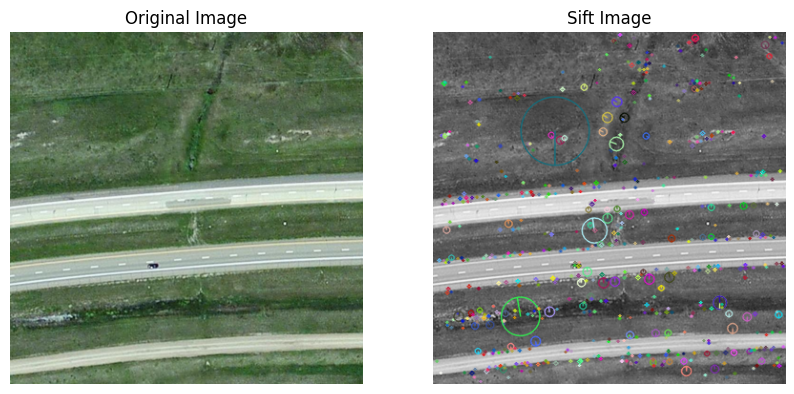

In [ ]:
Aerial_sift = []
Ground_sift = []

def extract_sift_keypoints(image_path, output_path):

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create()

    keypoints, descriptors = sift.detectAndCompute(image, None)

    if descriptors is not None:

        image_with_keypoints = cv2.drawKeypoints(
            image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        cv2.imwrite(output_path, image_with_keypoints)
    else:
        print("No descriptors found.")
        image_try = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        cv2.imwrite(output_path, image_try)


bingmap_files = os.listdir(bingmap_dir)
streetview_files = os.listdir(streetview_dir)


for file in tqdm(bingmap_files):
    if file.endswith(".png"):
        image_path = os.path.join(bingmap_dir, file)
        output_path = os.path.join("CVUSA_subset/sift_img/bingmap/", f"sift_visualized_{file}")
        extract_sift_keypoints(image_path, output_path)

for file in tqdm(streetview_files):
    if file.endswith(".jpg"):
        image_path = os.path.join(streetview_dir, file)
        output_path = os.path.join("CVUSA_subset/sift_img/streetview/", f"sift_visualized_{file}")
        extract_sift_keypoints(image_path, output_path)


## Depth and Segmentation Maps Generation

In this project, we generate **depth maps** and **segmentation maps** using state-of-the-art pre-trained models available on Hugging Face. Due to computational constraints, we opted for the smaller versions of these models to ensure efficiency without significantly sacrificing accuracy.

## Depth Map Generation

For generating depth maps, we utilized the **Depth-Anything-V2** model by Yang, which is known for its robust performance in estimating depth from images. We used the small version of this model to reduce computation time while still providing reliable depth estimations.


##Segmentation Map Generation

For segmentation maps, we employed the **Mask2Former model** developed by Facebook AI, specifically the small version trained for semantic segmentation. This model is effective in generating detailed segmentation maps, identifying various objects and regions within an image.

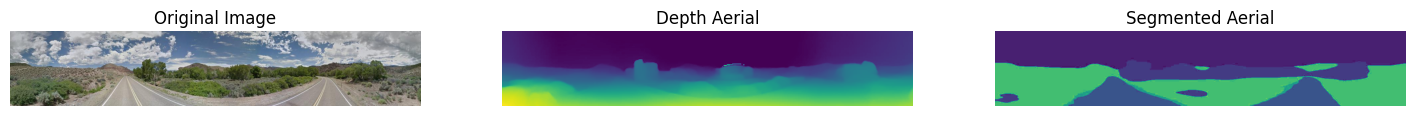

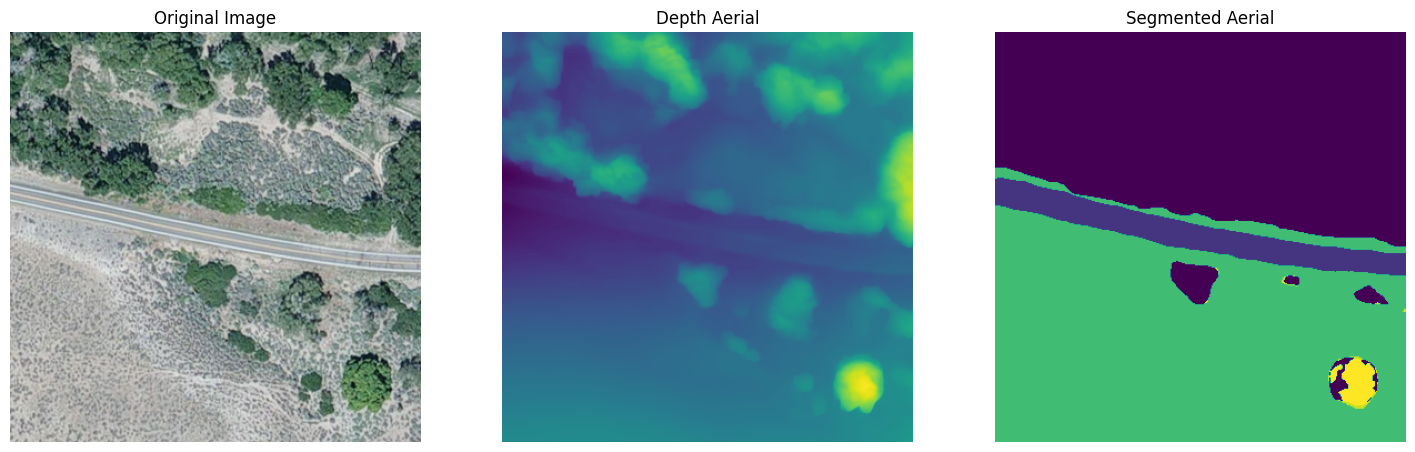


In [ ]:
depth_image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
depth_model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")

seg_processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-ade-semantic")
seg_model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-ade-semantic")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/82.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

In [ ]:
depth_aerial_dir = 'CVUSA_subset/depth_aerial'
seg_aerial_dir = 'CVUSA_subset/seg_aerial'
depth_ground_dir = 'CVUSA_subset/depth_ground'
seg_ground_dir = 'CVUSA_subset/seg_ground'

os.makedirs(depth_aerial_dir, exist_ok=True)
os.makedirs(seg_aerial_dir, exist_ok=True)
os.makedirs(depth_ground_dir, exist_ok=True)
os.makedirs(seg_ground_dir, exist_ok=True)

polar_dir = 'drive/MyDrive/CV/CVUSA_subset/polar_new'
bingmap_files = [os.path.join(bingmap_dir, f) for f in os.listdir(bingmap_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
streetview_files = [os.path.join(streetview_dir, f) for f in os.listdir(streetview_dir) if f.endswith(('png', 'jpg', 'jpeg'))]



def process_image(image_path, depth_output_dir, seg_output_dir):
    image = Image.open(image_path)

    # Process depth estimation
    depth_inputs = depth_image_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        depth_outputs = depth_model(**depth_inputs)
        predicted_depth = depth_outputs.predicted_depth
        depth_prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        ).squeeze().cpu().numpy()
    depth_output_path = os.path.join(depth_output_dir, os.path.basename(image_path))
    depth_image = Image.fromarray((depth_prediction * 255 / depth_prediction.max()).astype('uint8'))
    depth_image.save(depth_output_path)

    # Process segmentation
    seg_inputs = seg_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        seg_outputs = seg_model(**seg_inputs)
    predicted_segmentation = seg_processor.post_process_semantic_segmentation(seg_outputs, target_sizes=[image.size[::-1]])[0]
    seg_output_path = os.path.join(seg_output_dir, os.path.basename(image_path))
    seg_image = Image.fromarray(predicted_segmentation.numpy().astype('uint8'))
    seg_image.save(seg_output_path)

In [ ]:
for image_path in tqdm(bingmap_files):
    process_image(image_path, depth_aerial_dir, seg_aerial_dir)

In [ ]:
for image_path in tqdm(streetview_files):
    process_image(image_path, depth_ground_dir, seg_ground_dir)

## POLAR TRANSFORMATION

To reduce the domain gap between ground and aerial samples, we use a polar coordinate transformation for aerial images. This transformation is defined as follows:

### Transformation Equations


$$
x_i^s = \frac{W_s}{2} + \frac{W_s}{2} \frac{y_i^{ps}}{H_{ps}} \sin \left( \frac{2\pi}{W_{ps}} x_i^{ps} \right)
$$

$$
y_i^s = \frac{H_s}{2} - \frac{H_s}{2} \frac{y_i^{ps}}{H_{ps}} \cos \left( \frac{2\pi}{W_{ps}} x_i^{ps} \right)
$$


This polar coordinate transformation produces image pairs that better align with the content of the scene, maintaining a similar arrangement of objects. However, this alignment alone is not sufficient to completely close the domain gap between the views. The overlap between the images is often imperfect, and features that are not present in the top-view, such as the sky as seen from the ground view, cannot be recovered through this transformation.

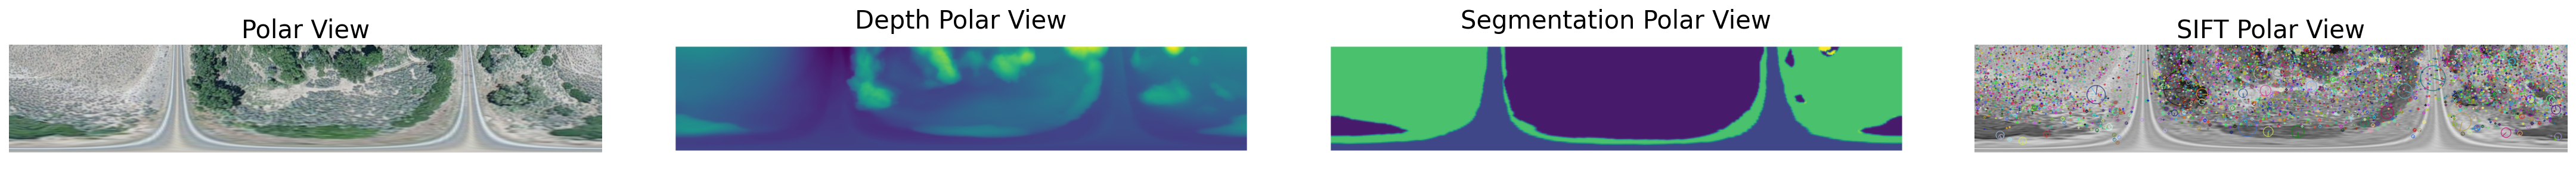

In [ ]:
# Taken from YujiaoShi/cross_view_localization_DSM

def sample_within_bounds(signal, x, y, bounds):

    xmin, xmax, ymin, ymax = bounds

    idxs = (xmin <= x) & (x < xmax) & (ymin <= y) & (y < ymax)

    sample = np.zeros((x.shape[0], x.shape[1], signal.shape[-1]))
    sample[idxs, :] = signal[x[idxs], y[idxs], :]

    return sample


def sample_bilinear(signal, rx, ry):

    signal_dim_x = signal.shape[0]
    signal_dim_y = signal.shape[1]

    # obtain four sample coordinates
    ix0 = rx.astype(int)
    iy0 = ry.astype(int)
    ix1 = ix0 + 1
    iy1 = iy0 + 1

    bounds = (0, signal_dim_x, 0, signal_dim_y)

    # sample signal at each four positions
    signal_00 = sample_within_bounds(signal, ix0, iy0, bounds)
    signal_10 = sample_within_bounds(signal, ix1, iy0, bounds)
    signal_01 = sample_within_bounds(signal, ix0, iy1, bounds)
    signal_11 = sample_within_bounds(signal, ix1, iy1, bounds)

    na = np.newaxis
    # linear interpolation in x-direction
    fx1 = (ix1-rx)[...,na] * signal_00 + (rx-ix0)[...,na] * signal_10
    fx2 = (ix1-rx)[...,na] * signal_01 + (rx-ix0)[...,na] * signal_11

    # linear interpolation in y-direction
    return (iy1 - ry)[...,na] * fx1 + (ry - iy0)[...,na] * fx2


S = 370  # Original size of the aerial image
height = 224  # Height of polar transformed aerial image
width = 1232   # Width of polar transformed aerial image

i = np.arange(0, height)
j = np.arange(0, width)
jj, ii = np.meshgrid(j, i)

y = S/2. - S/2./height*(height-1-ii)*np.sin(2*np.pi*jj/width)
x = S/2. + S/2./height*(height-1-ii)*np.cos(2*np.pi*jj/width)

input_dir = bingmap_dir
output_dir = 'CVUSA_subset/polar_new'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

images = os.listdir(input_dir)
for img in tqdm(images):

    img_path = os.path.join(input_dir, img)

    signal = cv2.imread(img_path)

    signal_rgb = cv2.cvtColor(signal, cv2.COLOR_BGR2RGB)

    normalized_signal = signal_rgb / 255.0

    image = sample_bilinear(normalized_signal, x, y)

    output_img_path = os.path.join(output_dir, img)
    image_bgr = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_img_path, image_bgr)

POLAR SEGMENTATION

In [ ]:
input_dir = bingmap_segmap_dir
output_dir = 'drive/MyDrive/CV/CVUSA_subset/polar_new_seg'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

images = os.listdir(input_dir)
for img in tqdm(images):

    img_path = os.path.join(input_dir, img)

    signal = cv2.imread(img_path)

    image = sample_bilinear(signal, x, y)

    output_img_path = os.path.join(output_dir, img)

    cv2.imwrite(output_img_path, image)

100%|██████████| 8862/8862 [28:27<00:00,  5.19it/s]


POLAR DEPTH

In [ ]:
input_dir = bingmap_depth_dir
output_dir = 'drive/MyDrive/CV/CVUSA_subset/polar_new_depth'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

images = os.listdir(input_dir)
for img in tqdm(images):

    img_path = os.path.join(input_dir, img)

    signal = cv2.imread(img_path)

    image = sample_bilinear(signal, x, y)

    output_img_path = os.path.join(output_dir, img)

    cv2.imwrite(output_img_path, image)

100%|██████████| 8862/8862 [28:03<00:00,  5.26it/s]


POLAR SIFT IMAGES

In [ ]:
Aerial_sift = []

polar_dir = 'drive/MyDrive/CV/CVUSA_subset/polar_new'

bingmap_files = os.listdir(polar_dir)
streetview_files = os.listdir(streetview_dir)

for file in tqdm(bingmap_files):
    if file.endswith(".png"):
        image_path = os.path.join(polar_dir, file)
        output_path = os.path.join("drive/MyDrive/CV/CVUSA_subset/polar_new_sift/", f"sift_visualized_{file}")
        extract_sift_keypoints(image_path, output_path)

## CSV Creation

To optimize the image loading process for our model, we have created CSV files that contain the paths to all input images. This approach ensures faster loading times and efficient data handling. We maintain two separate CSV files:

1. **Standard Dataset CSV**: Contains paths to the images in the standard dataset.
2. **Polar Dataset CSV**: Contains paths to the images in the polar dataset.

These CSV files serve as an index for the image datasets, allowing our model to quickly access the necessary files.


CSV STANDARD

In [ ]:
import os
import re
import csv

def extract_identifier(filename):
    match = re.search(r'\d+', filename)
    return match.group() if match else None

bingmap_files = sorted(os.listdir(bingmap_dir))
streetview_files = sorted(os.listdir(streetview_dir))
bingmap_sift_files = sorted(os.listdir(bingmap_sift_dir))
streetview_sift_files = sorted(os.listdir(streetview_sift_dir))
streetview_depth_files = sorted(os.listdir(streetview_depth_dir))
bingmap_depth_files = sorted(os.listdir(bingmap_depth_dir))
streetview_segmap_files = sorted(os.listdir(streetview_segmap_dir))
bingmap_segmap_files = sorted(os.listdir(bingmap_segmap_dir))


print(len(bingmap_files))
print(len(streetview_files))
print(len(bingmap_sift_files))
print(len(streetview_sift_files))
print(len(streetview_depth_files))
print(len(bingmap_depth_files))
print(len(streetview_segmap_files))
print(len(bingmap_segmap_files))

bingmap_dict = {extract_identifier(f): f for f in bingmap_files}
streetview_dict = {extract_identifier(f): f for f in streetview_files}
bingmap_sift_dict = {extract_identifier(f): f for f in bingmap_sift_files}
streetview_sift_dict = {extract_identifier(f): f for f in streetview_sift_files}
streetview_depth_dict = {extract_identifier(f): f for f in streetview_depth_files}
bingmap_depth_dict = {extract_identifier(f): f for f in bingmap_depth_files}
streetview_segmap_dict = {extract_identifier(f): f for f in streetview_segmap_files}
bingmap_segmap_dict = {extract_identifier(f): f for f in bingmap_segmap_files}

all_identifiers = set(bingmap_dict.keys()).union(
    streetview_dict.keys(),
    bingmap_sift_dict.keys(),
    streetview_sift_dict.keys(),
    streetview_depth_dict.keys(),
    bingmap_depth_dict.keys(),
    streetview_segmap_dict.keys(),
    bingmap_segmap_dict.keys()
)

# Write file paths to CSV
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    for identifier in all_identifiers:
        bingmap_file = bingmap_dict.get(identifier, "None")
        streetview_file = streetview_dict.get(identifier, "None")
        bingmap_sift_file = bingmap_sift_dict.get(identifier, "None")
        streetview_sift_file = streetview_sift_dict.get(identifier, "None")
        streetview_depth_file = streetview_depth_dict.get(identifier, "None")
        bingmap_depth_file = bingmap_depth_dict.get(identifier, "None")
        streetview_segmap_file = streetview_segmap_dict.get(identifier, "None")
        bingmap_segmap_file = bingmap_segmap_dict.get(identifier, "None")

        bingmap_path = f"{bingmap_dir}/{bingmap_file}" if bingmap_file != "None" else "None"
        streetview_path = f"{streetview_dir}/{streetview_file}" if streetview_file != "None" else "None"
        bingmap_sift_path = f"{bingmap_sift_dir}/{bingmap_sift_file}" if bingmap_sift_file != "None" else "None"
        streetview_sift_path = f"{streetview_sift_dir}/{streetview_sift_file}" if streetview_sift_file != "None" else "None"
        bingmap_depth_path = f"{bingmap_depth_dir}/{bingmap_depth_file}" if bingmap_depth_file != "None" else "None"
        streetview_depth_path = f"{streetview_depth_dir}/{streetview_depth_file}" if streetview_depth_file != "None" else "None"
        bingmap_segmap_path = f"{bingmap_segmap_dir}/{bingmap_segmap_file}" if bingmap_segmap_file != "None" else "None"
        streetview_segmap_path = f"{streetview_segmap_dir}/{streetview_segmap_file}" if streetview_segmap_file != "None" else "None"

        writer.writerow([bingmap_path, streetview_path, bingmap_sift_path, streetview_sift_path, bingmap_depth_path, streetview_depth_path, bingmap_segmap_path, streetview_segmap_path])

print(f"CSV creato con successo in {csv_path}")



8862
8862
8862
8862
8862
8862
8862
8862
CSV creato con successo in CVUSA_subset/file_paths.csv


CSV POLAR

In [ ]:
import pandas as pd

# Leggere il file CSV
csv_file_path = 'drive/MyDrive/CV/CVUSA_subset/file_paths.csv'  # Sostituisci con il percorso del tuo file
df = pd.read_csv(csv_file_path, header=None)

# Modificare le colonne specificate
df[0] = df[0].str.replace('bingmap', 'polar')                # Prima colonna
df[2] = df[2].str.replace('sift_img/bingmap', 'polar_sift')  # Terza colonna
df[4] = df[4].str.replace('depth/bingmap', 'polar_depth')    # Quinta colonna
df[6] = df[6].str.replace('segmap_new/bingmap', 'polar_seg') # Settima colonna

# Salvare il file modificato
output_csv_file_path = 'file_paths_polar.csv'  # Sostituisci con il percorso dove vuoi salvare il nuovo file
df.to_csv(output_csv_file_path, index=False, header=False)

print("File CSV modificato e salvato con successo!")

File CSV modificato e salvato con successo!
